In [1]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
from copy import deepcopy
import seaborn as sns

import hybdrt
from hybdrt.matrices import basis
from hybdrt.matrices.phasance import unit_phasor_impedance, unit_phasor_voltage
import hybdrt.plotting as hplt
from hybdrt.models import DRT, elements
from hybdrt import evaluation
import hybdrt.preprocessing as pp

from mitlef.pade_approx import create_approx_func

import fig_funcs as ff

%load_ext autoreload
%autoreload 2

In [2]:
# Plot formatting
full_width, half_width, light_colors, base_colors, dark_colors = ff.set_plot_formatting()

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

data_kw = dict(facecolors='none', edgecolors=[0.1] * 3)

# DOP response

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\utils\eis.py:11: RuntimeWarning: divide by zero encountered in true_divide
  Zphz = (180 / np.pi) * np.arctan(data.imag / data.real)
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\utils\eis.py:11: RuntimeWarning: divide by zero encountered in true_divide
  Zphz = (180 / np.pi) * np.arctan(data.imag / data.real)


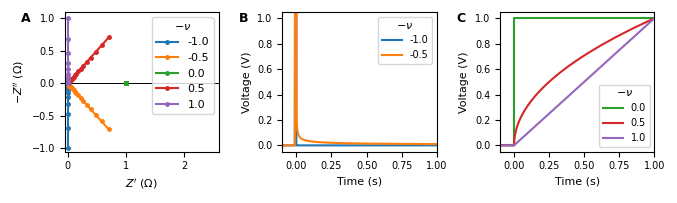

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3))

f = np.logspace(-4, 1, 31)
t = np.concatenate([np.linspace(-0.1, 0, 10), np.logspace(-7, 0, 101)])
for i, nu in enumerate(np.arange(1, -1.01, -0.5)):
#     nu = round(nu, 1)
    if nu == 0:
        label = 0.0
    else:
        label = -nu
        
    z = hybdrt.matrices.phasance.unit_phasor_impedance(f, nu)
    p = 1 / np.max(np.abs(z))
    z *= p
    
    v = np.zeros_like(t)
    if nu != 1:
        v[t > 0] = hybdrt.matrices.phasance.unit_phasor_voltage(t[t > 0], nu)
        v /= np.max(v[t > 1e-4])
    
    if nu > 0:
        v[t == 0] = 10
    
    hplt.plot_nyquist((f, z), ax=axes[0], scale_prefix='', label=label, plot_func='plot', marker='.', ms=5)
    
    if nu > 0:
        axes[1].plot(t, v, label=label)
    else:
        axes[2].plot(t, v, label=label, c=default_colors[i])
    
axes[0].legend(title=r'$-\nu$', ncol=1)
axes[0].set_xlim(np.array(axes[0].get_xlim()) - 0.05)

for ax in axes[1:]:
    ax.set_xlim(-0.1, 1)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)')
    ax.legend(title=r'$-\nu$', fontsize=7)

fig.tight_layout()
# fig.subplots_adjust(wspace=0.3)
ff.add_letters(axes, loc=(-0.28, 1))

ff.savefig(fig, 'Supp_Phasance_ZV')

# Compare z and v response

99% relaxed at 4.61*tau
99% relaxed at 9.95*tau


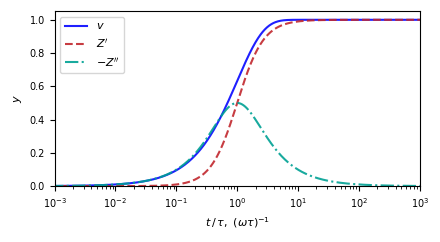

In [4]:
fig, ax = plt.subplots(figsize=(half_width, half_width * 0.55))

freq = np.logspace(5, -2, 1000)
omega = 2 * np.pi * freq
times = 1 / omega
tau = 1e-2
tt = times / tau

z = 1 / (1 + 1j * omega * tau)
v = 1 - np.exp(-times / tau)

ls = ['-', '--', '-.']
for i, (y, label) in enumerate(zip([v, z.real, -z.imag], ['$v$', r'$Z^{\prime}$', r'$-Z^{\prime\prime}$'])):
    ax.plot(tt, y, label=label, c=base_colors[i], alpha=0.9, ls=ls[i])
    
    if i < 2:
        print('99% relaxed at {:.2f}*tau'.format(np.interp(0.99, y, tt)))

ax.set_xscale('log')
ax.set_xlabel(r'$t \, / \, \tau, \ (\omega \tau)^{-1}$')
ax.set_ylabel(r'$y$')
ax.legend()
ax.set_xlim(1e-3, 1e3)
ax.set_ylim(0, 1.05)

fig.tight_layout()

ff.savefig(fig, 'Supp_CP_EIS_response-compare')

# Effect of non-ideal step

Discrepancy at x=100: -0.185 %


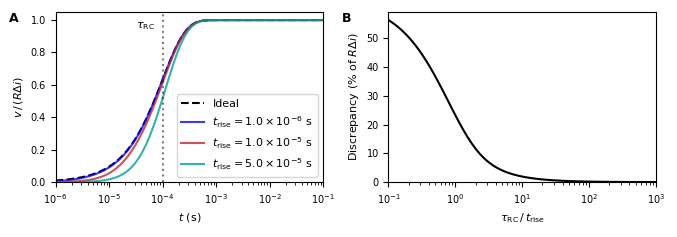

In [6]:
ideal_func = basis.get_response_func('delta', 'galv', 'ideal')
exp_func = basis.get_response_func('delta', 'galv', 'expdecay')

fig, axes = plt.subplots(1, 2, figsize=(full_width, full_width * 0.35))

# Show example of non-ideal response
tau = 1e-4
epsilon = 1

times = np.logspace(-6, 1, 100)
axes[0].plot(times, ideal_func(tau, times), c='k', label='Ideal', ls='--')

for i, t_rise in enumerate([1e-6, 1e-5, 5e-5]):
    tau_rise = t_rise / 2
    tr_pwr = int(np.floor(np.log10(t_rise)))
    tr_base = t_rise * 10 ** -tr_pwr
    tr_disp = r'{} \times 10^{{{}}}'.format(tr_base, tr_pwr)
    axes[0].plot(times, exp_func(tau, times, tau_rise), label=r'$t_{{\mathrm{{rise}}}}={}$ s'.format(tr_disp),
                c=base_colors[i], alpha=0.8)

# exp_sig = 1 - np.exp(-times / tau_rise)
# ax.plot(times, exp_sig, ls='--')

axes[0].set_xscale('log')
axes[0].set_xlabel('$t$ (s)')
axes[0].set_ylabel('$v \, / \, (R \Delta i)$')
axes[0].axvline(tau, ls=':', lw=1.5, c='k', alpha=0.5)
axes[0].text(0.3, 0.95, r'$\tau_{\mathrm{RC}}$', transform=axes[0].transAxes, va='top')
axes[0].legend()
axes[0].set_xlim(1e-6, 1e-1)
axes[0].set_ylim(0, axes[0].get_ylim()[1])

def offset_x(x):
    # x = tau / t_rise. Assume t - t_0 = tau
    return (1 / (1 - 2 * x)) * (np.exp(-1) - np.exp(-2 * x))

print('Discrepancy at x=100: {:.3f} %'.format(offset_x(100) * 100))

x = np.logspace(-1, 3, 100)
axes[1].plot(x, np.abs(100 * offset_x(x)), c='k')
axes[1].set_xscale('log')
axes[1].set_xlabel(r'$\tau_{\mathrm{RC}} \, / \, t_{\mathrm{rise}}$')
axes[1].set_ylabel(r'Discrepancy (% of $R \Delta i$)')
axes[1].set_xlim(1e-1, 1e3)
axes[1].set_ylim(0, axes[1].get_ylim()[1])

fig.tight_layout()
ff.add_letters(axes, loc=(-0.175, 1.0))

ff.savefig(fig, 'Supp_nonideal_error')

# Antialiasing filter

10
10


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

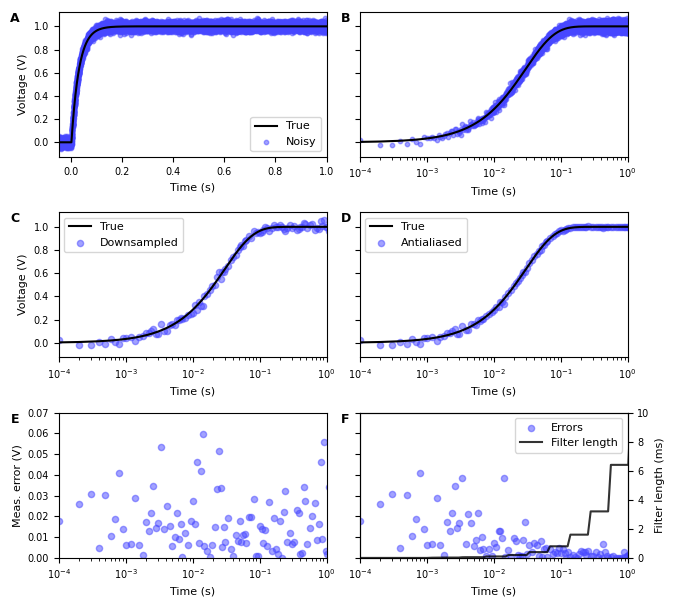

In [7]:
t_sample = 1e-4

times = np.arange(-0.1, 1.1 + t_sample, t_sample)

i_signal = np.heaviside(times, 0)
v_signal = np.zeros_like(times)
v_signal[times > 0] = 1 - np.exp(-times[times > 0] / 3e-2)



rng = np.random.default_rng(1893)

noise = rng.normal(0, 0.02, len(times))
v_noisy = v_signal + noise


ds_kw = dict(step_model='ideal', method='decimate', decimation_interval=10, decimation_factor=2)

t_ds, i_ds, v_ds, sample_index = pp.downsample_data(times, i_signal, v_noisy, **ds_kw, antialiased=False)

t_aa, i_aa, v_aa, sample_index = pp.downsample_data(times, i_signal, v_noisy, **ds_kw, antialiased=True)


sigma_factor = 0.01
sigma_ideal = np.exp(1) * times / 2
sigmas = sigma_factor * (sigma_ideal / t_sample)
sigma_dec = pp.sigma_from_decimate_index(times, sample_index)
sigmas = np.minimum(sigmas, sigma_dec)
sigmas = sigmas[sample_index]

# fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3), sharex=True, sharey=True)
fig, axes = plt.subplots(3, 2, figsize=(full_width, full_width * 0.9), sharex=False, sharey=False)

axes[0, 0].get_shared_y_axes().join(*axes.ravel()[:4])
axes[2, 0].get_shared_y_axes().join(*axes[2])

for ax in axes.ravel()[:4]:
    ax.plot(times, v_signal, c='k', label='True')
    
axes[0, 0].scatter(times, v_noisy, s=10, alpha=0.5, label='Noisy', c=light_colors[0])
axes[0, 1].scatter(times, v_noisy, s=10, alpha=0.5, c=light_colors[0])

axes[1, 0].scatter(t_ds, v_ds, s=20, alpha=0.5, label='Downsampled', c=light_colors[0])
axes[1, 1].scatter(t_ds, v_aa, s=20, alpha=0.5, label='Antialiased', c=light_colors[0])

axes[2, 0].scatter(t_ds, np.abs(v_ds - v_signal[sample_index]), s=20, alpha=0.5, c=light_colors[0])
axes[2, 1].scatter(t_ds, np.abs(v_aa - v_signal[sample_index]), s=20, alpha=0.5, label='Errors', c=light_colors[0])

axt = axes[2, 1].twinx()
axt.plot(t_ds, 1000 * sigmas * t_sample, c='k', label='Filter length', alpha=0.8)

# Format x-axis
axes[0, 0].set_xlim(-0.05, 1)
for ax in axes.ravel()[1:]:
    ax.set_xscale('log')
# ax.set_xscale('log')
    ax.set_xlim(t_sample, 1)
    
for ax in axes.ravel():
    ax.set_xlabel('Time (s)')
    
# Set shared y labels
for ax in axes[:2, 0]:
    ax.set_ylabel('Voltage (V)')
    
axes[2, 0].set_ylabel('Meas. error (V)')
axes[2, 0].set_ylim(0, 0.07)
axt.set_ylim(0, 10)
axt.set_ylabel('Filter length (ms)')

# Clear 2nd column y ticklabels
for ax in axes[:, 1]:
    ax.set_yticklabels([])
    
# Legends
axes[0, 0].legend()
axes[1, 0].legend()
axes[1, 1].legend(loc='upper left')

h1, l1 = axes[2, 1].get_legend_handles_labels()
h2, l2 = axt.get_legend_handles_labels()
axes[2, 1].legend(handles=h1 + h2, labels=l1 + l2)
    

fig.tight_layout()

loci = [(-0.18, 1), (-0.07, 1)] * 3
ff.add_letters(axes, loc=loci)

ff.savefig(fig, 'Supp_AntialisingSim')

## Simulated experiment
Simulate EIS and hybrid spectra to validate hybrid inversion accuracy.

In [5]:
def make_basic_signal(t, s_init, step_times, step_sizes, step_offset=1e-6):
    t = np.round(t, 8)
    i_signal = np.zeros(len(t)) + s_init
    for st, ss in zip(step_times, step_sizes):
        i_signal[t >= st + step_offset] += ss
        
    return i_signal

    
def make_geostep_signal(s_init, s_final, s_min, s_max, t_init, t_sample, t_short, t_long,
                        num_scales, steps_per_scale, flex_thresh=0.05, step_offset=1e-6):
    if s_max <= s_min:
        raise ValueError(f's_max must be greater than s_min. Received s_min={s_min}, s_max={s_max}')

    if t_short >= t_long:
        raise ValueError('t_short must be less than t_long')

    if t_short <= t_sample:
        raise ValueError('t_short must be greater than t_sample')

    if num_scales < 2:
        raise ValueError(f'Geostep requires at least 2 duration scales (num_scales); received {num_scales}')

    if steps_per_scale < 1 or steps_per_scale > 3:
        raise ValueError(f'steps_per_scale must be between 1 and 3; received {steps_per_scale}')

    # Build the signal array
    # Get logarithmically spaces step lengths
    step_durations = np.logspace(np.log10(t_short), np.log10(t_long), num_scales)
    # Round to integer number of sample periods
    step_durations = np.array([round(sd / t_sample, 0) * t_sample for sd in step_durations])
    print('geostep step_durations:', step_durations)

    # Make the first step in the direction that maximizes magnitude
    s_range = s_max - s_min
    if abs((s_init - s_min) - (s_max - s_init)) < s_range * flex_thresh:
        # s_init is at center of range - first step sign is flexible
        init_sign = 0
        print('init flex')
    elif abs(s_init - s_min) > abs(s_init - s_max):
        init_sign = -1
    else:
        init_sign = 1

    # Make the last step in the direction that maximizes magnitude
    if abs((s_final - s_min) - (s_max - s_final)) < s_range * flex_thresh and init_sign != 0:
        # Flexible last step
        final_sign = 0
        print('final flex')
    elif abs(s_final - s_min) > abs(s_final - s_max):
        final_sign = 1
    else:
        final_sign = -1

    # Check if the initial and final signs are aligned.
    # If not, add a "stutter step" at the shortest timescale to align them
    tot_num_steps = num_scales * steps_per_scale
    stutter = False
    sign_switch = (-1) ** (tot_num_steps - 1)
    if init_sign == 0:
        init_sign = final_sign * sign_switch
    elif final_sign == 0:
        final_sign = init_sign * sign_switch
    elif init_sign * sign_switch != final_sign:
        stutter = True

    # Starting offset to align steps (will be overwritten when s_init is set)
    if init_sign == -1:
        signal_offset = s_max
    else:
        signal_offset = s_min

    # Get sample times
    duration = t_init + steps_per_scale * np.sum(step_durations) + int(stutter) * step_durations[0]
    times = np.arange(0, duration + 1e-8, t_sample)

    signal = np.zeros(len(times)) + signal_offset
    step_times = []

    print('init_sign:', init_sign)
    print('final_sign:', final_sign)
    print('stutter:', stutter)

    # Intermediate scales
    step_time = np.round(t_init, 8)
    sign = init_sign
    for i, step_duration in enumerate(step_durations):
        if stutter and i == 0:
            num_steps = steps_per_scale + 1
        else:
            num_steps = steps_per_scale

        for j in range(num_steps):
            # Step at the sample after the step time to mimic real data
            signal[times >= step_time + step_offset] += sign * s_range
            step_times.append(np.round(step_time, 8))
            step_time += np.round(step_duration, 8)
            sign *= -1

    # Set initial and final values
    signal[times < step_times[0] + step_offset] = s_init
    signal[times >= step_times[-1] + step_offset] = s_final

    return times, signal, step_times


def calc_v(t, i_signal, step_times, param_list, r_inf, step_offset=1e-6):
    # Get step indices and sizes
    step_index = [hybdrt.utils.array.nearest_index(t, st + step_offset, constraint=-1) for st in step_times]
    step_sizes = [i_signal[si + 1] - i_signal[si] for si in step_index]
    print(step_sizes)
    
    # Get RQ contributions
    v_rq = basis.get_response_func('Cole-Cole', 'galv', 'ideal')
#     ml_func = create_approx_func(eps_ml, eps_ml + 1)
    v_out = np.zeros(len(t))
    
    for i, st in enumerate(step_times):
        post_times = t[t > st + step_offset]
        print((post_times - (st))[:5])
        v_list = [p[0] * v_rq(p[1], post_times - (st + step_offset), p[2], None) for p in param_list]
        v_out[t > st + step_offset] += step_sizes[i] * np.sum(np.array(v_list), axis=0)
        
        # Get R_inf contribution
        v_out[t > st + step_offset] += step_sizes[i] * r_inf
    
    return v_out


def calc_drt(tau, param_list):
    phi_rq = basis.get_basis_func('Cole-Cole')
    gamma_list = [p[0] * phi_rq(np.log(tau / p[1]), p[2]) for p in param_list]
    return np.sum(np.array(gamma_list), axis=0)


def calc_z(f, param_list):
    zr_rq = basis.get_impedance_func('real', 'Cole-Cole')
    zi_rq = basis.get_impedance_func('imag', 'Cole-Cole')
    z_rq = lambda *x: zr_rq(*x) + 1j * zi_rq(*x)
    z_list = [p[0] * z_rq(f * 2 * np.pi, p[1], p[2]) for p in param_list]
    return np.sum(np.array(z_list), axis=0)


def generate_z_noise(z, rng, scale, structure=None):
    if structure is None:
        zn = rng.normal(0, scale, size=len(z)) + 1j * rng.normal(0, scale, size=len(z))
    elif structure == 'modulus':
        zmod = np.abs(z)
        scale = scale * zmod / np.mean(zmod)
        zn = rng.normal(0, scale) + 1j * rng.normal(0, scale)
        
    return zn


def generate_v_noise(v, rng, scale):
    vn = rng.normal(0, scale, size=len(v))
    return vn

In [6]:
exact_model = elements.DiscreteElementModel('R0-L0-RQ1-RQ2-RQ3-RQ4')
rq_params = [
    # R, tau, alpha
    (0.25, np.log(1e-5), 0.8),
    (0.25, np.log(1e-4), 0.8),
    (0.25, np.log(1e-3), 0.8),
    (0.25, np.log(1e-2), 0.8),
]
r_inf = 0.1
L = 1e-7
r_p = np.sum([p[0] for p in rq_params])
r_tot = r_inf + r_p

exact_model.parameter_values = np.concatenate([[r_inf, np.log(L)]] + rq_params)
exact_model.parameter_dict

tau_plot = np.logspace(-8, 2, 201)
freq = np.logspace(6, -1, 141)

gamma_true = exact_model.predict_distribution(tau_plot)
z_true = exact_model.predict_z(freq)

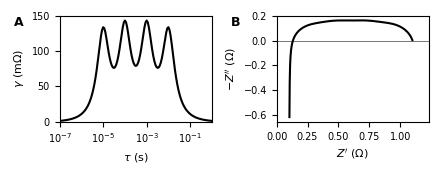

In [7]:
# Show true DRT and impedance
fig, axes = plt.subplots(1, 2, figsize=(half_width, half_width * 0.4))

exact_model.plot_distribution(tau_plot, ax=axes[0], c='k', alpha=1)

hplt.plot_nyquist((freq, z_true), ax=axes[1], plot_func='plot', c='k')

axes[0].set_xlim(1e-7, 1e0)
axes[0].set_ylim(0, 150)

ff.add_letters(axes, loc=(-0.3, 1))

ff.savefig(fig, 'Supp_SimDRT')

geostep step_durations: [0.001 0.01  0.1   1.   ]
init flex
init_sign: 1
final_sign: -1
stutter: False


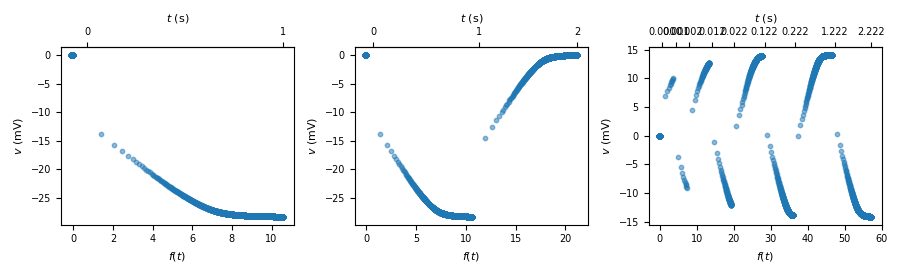

In [8]:
# Generate time-domain voltage signals for different step types

t_sample = 1e-4
# Set current step size
v_rms = 0.01
i_rms = v_rms / r_tot
i_half_step = i_rms * np.sqrt(2)

t1 = np.arange(-0.1, 1, 1e-4)
single_step_times = np.array([0])
i_single = make_basic_signal(t1, i_half_step, single_step_times, [-2 * i_half_step])

t2 = np.arange(-0.1, 2, 1e-4)
pulse_step_times = np.array([0, 1])
i_pulse = make_basic_signal(t2, i_half_step, pulse_step_times, [-2 * i_half_step, 2 * i_half_step])

t3, i_geo, geo_step_times = make_geostep_signal(0, -i_half_step, -i_half_step, i_half_step, 0.1, t_sample, 
                                                0.001, 1, 4, 2)
t3 -= geo_step_times[0]
geo_step_times -= geo_step_times[0]
# s_init, s_final, s_min, s_max,

cp_data = {
    'Single': {'times': t1, 'i': i_single, 'step_times': single_step_times + 1e-6},
    'Pulse': {'times': t2, 'i': i_pulse, 'step_times': pulse_step_times + 1e-6},
    'Geometric': {'times': t3, 'i': i_geo, 'step_times': geo_step_times + 1e-6}
}

for key in list(cp_data.keys()):
    times = cp_data[key]['times']
    i_signal = cp_data[key]['i']
    step_times = cp_data[key]['step_times']
    step_sizes = hybdrt.preprocessing.get_step_sizes(times, i_signal, step_times)
#     v_true = calc_v(t, i_signal, step_times, rq_params, r_inf)
#     v_true += i_signal[0] * r_tot
    # Offset step_times by 1e-6 s so that each step occurs just after the sample time,
#     like it does in real experiments
    v_true = exact_model.predict_v(times, np.array(step_times), step_sizes)
    cp_data[key]['v_true'] = v_true

                                                
fig, axes = plt.subplots(1, 3, figsize=(9, 2.75))
for ax, (key, info) in zip(axes, cp_data.items()):
    hplt.plot_chrono((info['times'], info['i'], info['v_true']), axes=ax, plot_i=False, 
                     step_times=info['step_times'], transform_time=True, linear_time_axis=True)

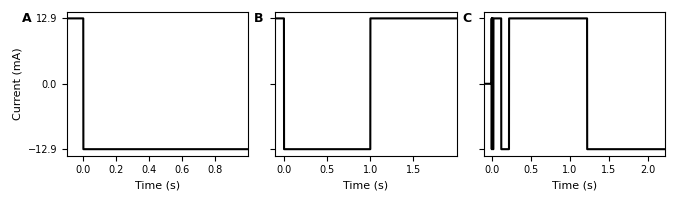

In [9]:
# Show simulated current signals

fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3), sharey=True)

for i, (key, val) in enumerate(cp_data.items()):
    ax = axes[i]
    ax.plot(val['times'], 1000 * val['i'], c='k')
    ax.set_xlim(val['times'][0], val['times'][-1])
    ax.set_xlabel('Time (s)')
    
axes[0].set_ylabel('Current (mA)')
axes[0].set_yticks([round(-1000 * i_half_step, 1), 0, round(1000 * i_half_step, 1)])
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.15)
ff.add_letters(axes, loc=[(-0.25, 1)] + [(-0.12, 1)] * 2)

ff.savefig(fig, 'Supp_SimSignals')

In [10]:
# Simulate and fit conventional EIS
n_spectra = 100

eis_drt = DRT()

# Add random noise
rng = np.random.default_rng(23589)
eis_noise_frac = 0.001
z_noisy = np.empty((n_spectra, len(z_true)), dtype=complex)
eis_fits = {'10ppd': []}  # , '20ppd': []}

for i in range(n_spectra):
    z_noisy[i] = z_true + generate_z_noise(z_true, rng, r_p * eis_noise_frac, structure=None)
    
    for ppd in [10]:
        inc = int(20 / ppd)
        key = f'{ppd}ppd'
        eis_drt.fit_eis(freq[::inc], z_noisy[i, ::inc], nonneg=True)
        eis_fits[key].append(deepcopy(eis_drt))
    

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


In [11]:
# Score EIS fits
ds = evaluation.DrtScorer()

eis_scores = {k: {} for k in eis_fits.keys()}
for key in eis_fits.keys():
    eis_scores[key]['r2'] = np.empty(n_spectra)
    eis_scores[key]['f_kl'] = np.empty(n_spectra)
    for i in range(n_spectra):
        scores = ds.evaluate_models(exact_model, eis_fits[key][i], tau_reg=np.logspace(-8, 2, 101), 
                                    tau_cls=np.logspace(-8, 2, 101))
        for sk in ['r2', 'f_kl']:
            eis_scores[key][sk][i] = scores[sk]

False
thresh: 0.010596094348407515
thresh: 0.008679617612430749
False
thresh: 0.010596094348407515
thresh: 0.008483084414590811
False
thresh: 0.010596094348407515
thresh: 0.00875211673855215
False
thresh: 0.010596094348407515
thresh: 0.008660999942931385
False
thresh: 0.010596094348407515
thresh: 0.00953626087556439
False
thresh: 0.010596094348407515
thresh: 0.008353693262896493
False
thresh: 0.010596094348407515
thresh: 0.008584586515590407
False
thresh: 0.010596094348407515
thresh: 0.008981146541809742
False
thresh: 0.010596094348407515
thresh: 0.008546064275991416
False
thresh: 0.010596094348407515
thresh: 0.008551545507184528
False
thresh: 0.010596094348407515
thresh: 0.009906407367693684
False
thresh: 0.010596094348407515
thresh: 0.008017195076726017
False
thresh: 0.010596094348407515
thresh: 0.00875808236748633
False
thresh: 0.010596094348407515
thresh: 0.00812131743072345
False
thresh: 0.010596094348407515
thresh: 0.008321591252699956
False
thresh: 0.010596094348407515
thresh: 0

In [12]:
# Generate and fit hybrid data
cp_fits = {k: {} for k in cp_data.keys()}
cp_drt = DRT(fit_inductance=True)

rng = np.random.default_rng(4892)

for snr_ratio in [2, 4]:
    print(f'SNR ratio {snr_ratio}')
    for key in list(cp_data.keys()):
        info = cp_data[key]
        times = info['times']
        step_times = info['step_times']
        i_signal = info['i']
        v_true = info['v_true']
        
        v_noisy = np.empty((n_spectra, len(v_true)))
        
        cp_fits[key][snr_ratio] = []
        
        # Add noise
        for i in range(n_spectra):
            vn_scale = r_p * eis_noise_frac * snr_ratio * (2 * i_half_step)
            v_noisy[i] = v_true + generate_v_noise(v_true, rng, vn_scale)
            
            cp_drt.print_diagnostics = False
#             cp_drt.fit_inductance = False  # for pure chrono fit
#             cp_drt.fit_chrono(times, i_signal, v_noisy[i], downsample=True,
#                           downsample_kw={'method': 'decimate', 'target_size': 1000, 'antialiased': True}
#                          )
            cp_drt.fit_hybrid(times, i_signal, v_noisy[i], freq[:61:2], z_noisy[i, :61:2], downsample=True,
                          downsample_kw={'method': 'decimate', 'target_size': 1000, 'antialiased': True,
                                         'decimation_factor': 2},
                             step_times=step_times,
                          hybrid_weight_factor_method=None
                         )
            cp_fits[key][snr_ratio].append(deepcopy(cp_drt))
            
            if (i + 1) % 10 == 0:
                print(f'{i + 1}/{n_spectra}')
            
        cp_data[key][f'v_noisy_{snr_ratio}'] = v_noisy

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
3

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31


In [13]:
# Score hybrid fits
ds = evaluation.DrtScorer()

cp_scores = {k: {} for k in cp_fits.keys()}
for key in cp_fits.keys():
    cp_scores[key] = {snr: {} for snr in cp_fits[key].keys()}
    for snr in cp_fits[key].keys():
        cp_scores[key][snr]['r2'] = np.empty(n_spectra)
        cp_scores[key][snr]['f_kl'] = np.empty(n_spectra)
        for i in range(n_spectra):
            scores = ds.evaluate_models(exact_model, cp_fits[key][snr][i], tau_reg=np.logspace(-8, 2, 101), 
                                        tau_cls=np.logspace(-8, 2, 101))
            for sk in ['r2', 'f_kl']:
                cp_scores[key][snr][sk][i] = scores[sk]
                
            

Single 2 r2 0.980 +/- 0.005
Single 4 r2 0.968 +/- 0.005
Pulse 2 r2 0.986 +/- 0.005
Pulse 4 r2 0.974 +/- 0.005
Geometric 2 r2 0.990 +/- 0.003
Geometric 4 r2 0.980 +/- 0.006


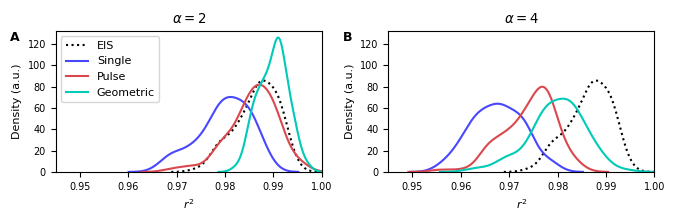

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(full_width, full_width * 0.33), sharex=False, sharey=False)

axes[0].get_shared_x_axes().join(*axes)
axes[0].get_shared_y_axes().join(*axes)

met_list = ['r2'] #, 'fkl']
for j, metric in enumerate(met_list):
    vals = eis_scores['10ppd'][metric]
    for ax in axes:
        sns.kdeplot(vals, ax=ax, color='k', ls=':', label='EIS')
        
        
met_labels = ['$r^2$', '$f_{\mathrm{KL}}$']
for k, signal in enumerate(['Single', 'Pulse', 'Geometric']):
    for i, snr in enumerate(cp_scores[signal].keys()):
        for j, metric in enumerate(met_list):
            ax = axes[i]
            vals = cp_scores[signal][snr][metric]
            print(signal, snr, metric, '{:.3f} +/- {:.3f}'.format(np.mean(vals), np.std(vals)))
#             sns.histplot(vals, ax=ax, kde=True, color=light_colors[k])
            sns.kdeplot(vals, ax=ax, color=light_colors[k], label=signal)
                
            ax.set_title(fr'$\alpha={snr}$')
        
for ax in axes:
    ax.set_xlabel('$r^2$')
    
for ax in axes.ravel():
    ax.set_xlim(0.945, 1.0)
    ax.set_ylabel('Density (a.u.)')
    

axes[0].legend(loc='upper left')

ff.add_letters(axes, loc=(-0.17, 1))
            
fig.tight_layout()

ff.savefig(fig, 'Supp_SimMetricDistributions')

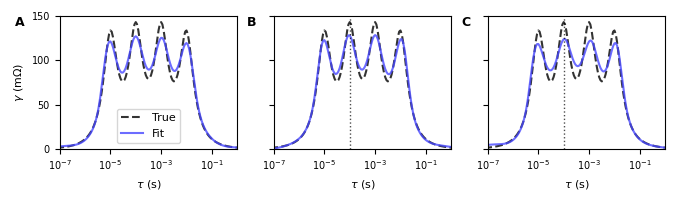

In [16]:
# Plot representative fit for each spectrum type
def get_median_fit(scores, fits):
    sort_index = np.argsort(scores)
    med_index = sort_index[int(len(scores) / 2)]
    return fits[med_index]

med_fits = {
    'EIS': get_median_fit(eis_scores['10ppd']['r2'], eis_fits['10ppd']),
    r'Geo. ($\alpha=2$)': get_median_fit(cp_scores['Geometric'][2]['r2'], cp_fits['Geometric'][2]),
    r'Geo. ($\alpha=4$)': get_median_fit(cp_scores['Geometric'][4]['r2'], cp_fits['Geometric'][4]),
}


fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3), sharex=True, sharey=True)

for i, (key, fit) in enumerate(med_fits.items()):
    drt_ax = axes[i]
    
    drt_ax.plot(tau_plot, 1000 * gamma_true, c='k', alpha=0.8, ls='--', label='True')
    fit.plot_distribution(ax=drt_ax, c=light_colors[0], ls='-', alpha=0.8, label='Fit')

    drt_ax.set_xlim(1e-7, 1e0)
    drt_ax.set_ylim(0, drt_ax.get_ylim()[1])
    
    
for ax in axes[1:]:
    ax.set_ylabel('')
    ax.axvline(t_sample, ls=':', alpha=0.7, lw=1, c='k')
    
axes[0].legend(loc='lower center')
    
    
ff.add_letters(axes, loc=[(-0.25, 1)] + [(-0.15, 1)] * 2)

ff.savefig(fig, 'Supp_SimMedianDRTs')